# Chapter 8

Zachary Campbell Week 8 - Assignment 8.2 (Ex 9-1 and 10-1)



In [28]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [29]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [30]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [31]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [32]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.073

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [33]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [34]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [35]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [36]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.18

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

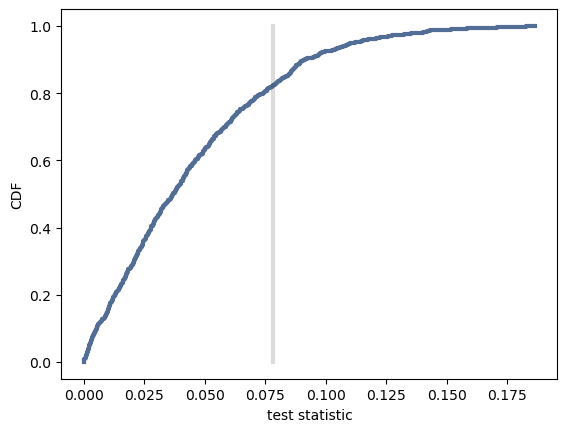

In [37]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [38]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [39]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.077

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [40]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [41]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.08

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [42]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [43]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [44]:
ht.actual, ht.MaxTestStat()

(0.06883397035410911, 0.03708207622952577)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [45]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [46]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1304

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [47]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [48]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.04

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [49]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [50]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 26.809453179342658


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [51]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [52]:
neg_rate = FalseNegRate(data)
neg_rate

0.696

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise 9-1:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [58]:
# creating a function that will perform all the testing.
def newTests(live, iters=1000):
    # This runs the tests from chapter 9 with a smaller set of data.
    # live is the data frame we are pulling the data from
    # iters is how many iterations to run
    n = len(live)
    firstBorn = live[live.birthord == 1]
    nonFirst = live[live.birthord != 1]
    
    # the below will compare the overall pregnancy lengths
    data = firstBorn.prglngth.values, nonFirst.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)
    
    data = (firstBorn.totalwgt_lb.dropna().values, nonFirst.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)
    
    #Testing the correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)
    
    #compare the preg lengths using Chi-squared
    data = firstBorn.prglngth.values, nonFirst.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)
    
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [59]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    newTests(sample)
    n //= 2

9148	0.16	0.00	0.00	0.00
4574	0.56	0.01	0.00	0.00
2287	0.68	0.15	0.00	0.00
1143	0.27	0.04	0.00	0.02
571	0.24	0.40	0.05	0.00
285	0.78	0.12	0.56	0.69
142	0.64	0.34	0.31	0.79


# My Results are as follows:

Test 1: It shows the difference in the mean pregnancy length and is attempting to quantify the differences to see if there is actual results.

Test 2: It shows the difference in the mean birth weight which is the dependent variable we are attempting to quantify.

Test 3: This determines a correlation between the mean pregnancy length and the mean birth weight.

Test 4: Chi-square test to determine the statistical significance of the tests performed.

  N      T1      T2      T3      T4 
9148	0.16	0.00	0.00	0.00
4574	0.56	0.01	0.00	0.00
2287	0.68	0.15	0.00	0.00
1143	0.27	0.04	0.00	0.02
 571	0.24	0.40	0.05	0.00
 285	0.78	0.12	0.56	0.69
 142	0.64	0.34	0.31	0.79

Conclusion:
Based on the results it was not 100% clear as to the effect of one variable on the other when samples are taken from a larger population. This method of evaluation does not work for the data that we are testing as it benefits from increased population size and application of the model

# Chapter 10

Zachary Campbell Week 9 - Assignment 9.2 (Ex 9-1 and 10-1)



In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [4]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

The following function computes the intercept and slope of the least squares fit.

In [5]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [6]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.01745385147180276)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [7]:
inter + slope * 25

7.2667432601061215

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [8]:
slope * 10

0.1745385147180276

The following function evaluates the fitted line at the given `xs`.

In [9]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [10]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

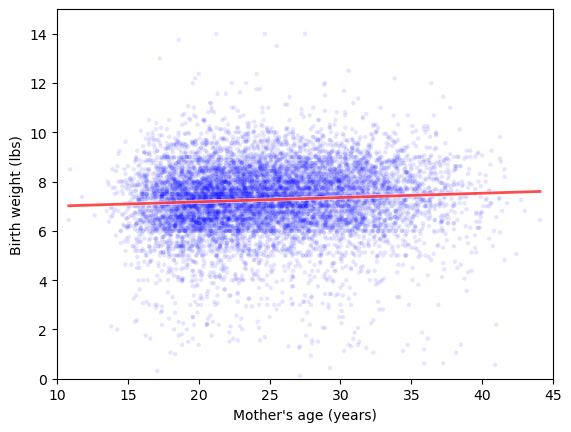

In [11]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following functon computes the residuals.

In [12]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [13]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [14]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [15]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [16]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

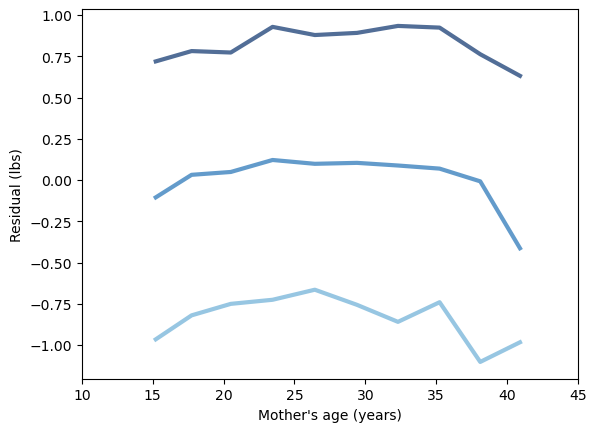

In [17]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [18]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [19]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [20]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [21]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [22]:
Summarize(inters)

mean, SE, CI 6.831725684350781 0.07099990876607519 (6.7168629692754465, 6.945616971518678)


And for `slope`.

In [23]:
Summarize(slopes)

mean, SE, CI 0.01743008183117817 0.002798598525885482 (0.01286781433096071, 0.0221307071499937)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [24]:
iters = 1000
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.2653958771298965 0.015118826972297673 (7.239647875636202, 7.290564837353397)


## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

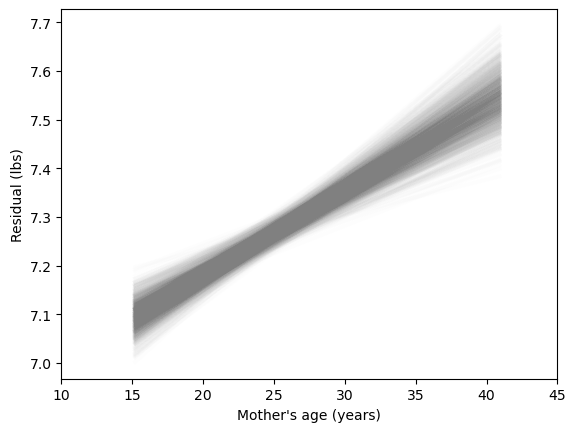

In [25]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [26]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

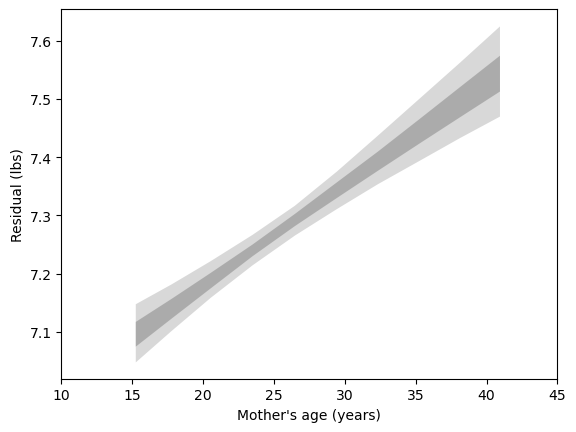

In [27]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [28]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [29]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710036

We can confirm that $R^2 = \rho^2$:

In [30]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410911
R 0.06883397035410667


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [31]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.4082155338406197
Std(res) 1.4048754287857834


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [32]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [33]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [34]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [35]:
ht.actual, ht.MaxTestStat()

(0.01745385147180276, 0.009012264209879148)

We can also use resampling to estimate the sampling distribution of the slope.

In [36]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

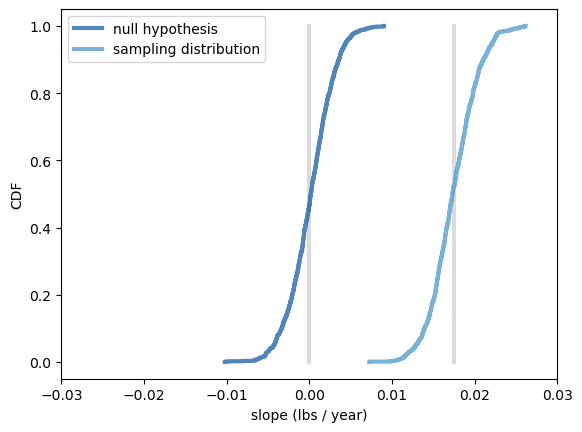

In [37]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [38]:
pvalue = sampling_cdf[0]
pvalue

0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [39]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [40]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.350174886589955 0.012981529496815223 (7.33189726709449, 7.372268477539278)


And here's what the same calculation looks like if we ignore the weights.

In [41]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.264568834366011 0.01357651337387085 (7.241611805709228, 7.283725658331489)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

# EXERCISE 10-1

# Exercises

**Exercise 10-1:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [42]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [43]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [44]:
# Solution
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917826, 0.005281454169417984)

Make a scatter plot of the data and show the fitted line.

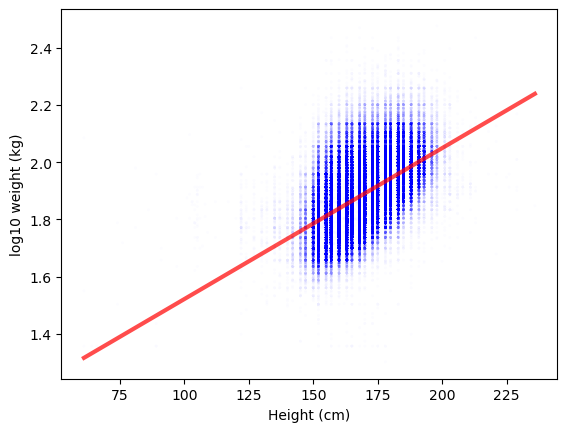

In [45]:
#Solution 
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

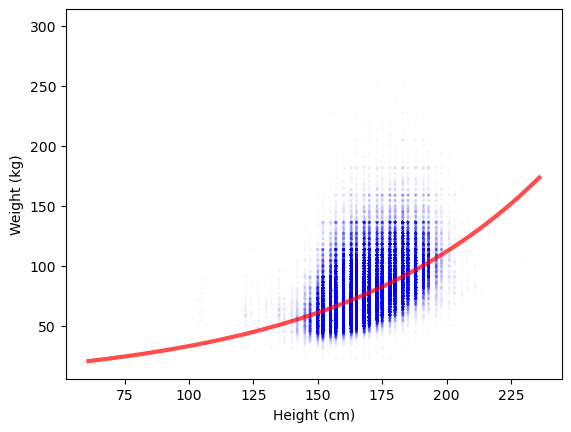

In [46]:
# Solution

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plot percentiles of the residuals.

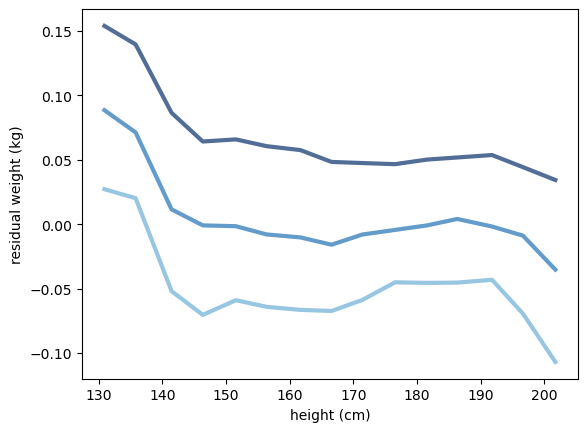

In [47]:
 # Solution

# The lines are flat over most of the range, which could mean that the relationship is mainly linear

# The lines are relatively parallel to each other, what this means is that the variance of the residuals is roughly the same throughout the range of data

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

Compute correlation.

In [48]:
# Solution

rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983571

Compute coefficient of determination.

In [49]:
# Solution

r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.2827349431189321

Confirm that $R^2 = \rho^2$.

In [50]:
# Solution

rho**2 - r2

2.225997164373439e-14

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [51]:
# Solution

std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004867

Compute Std(res), the RMSE of predictions that do use height.

In [52]:
# Solution

std_res = thinkstats2.Std(res)
std_res

0.08740777080416114

How much does height information reduce RMSE?

In [53]:
# Solution

1 - std_res / std_ys

0.15308497658792952

Use resampling to compute sampling distributions for inter and slope.

In [54]:
# Solution

t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

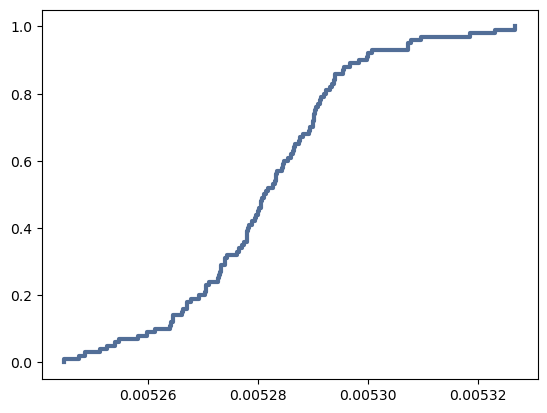

In [55]:
# Solution

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [56]:
# Solution

pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [57]:
# Solution

ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005252479002761344, 0.00530725361580852)

Compute the mean of the sampling distribution.

In [58]:
# Solution

mean = thinkstats2.Mean(slopes)
mean

0.0052813927306907225

Compute the standard deviation of the sampling distribution, which is the standard error.

In [59]:
# Solution

stderr = thinkstats2.Std(slopes)
stderr

1.543494443324923e-05

Resample rows without weights, compute mean height, and summarize results.

In [60]:
# Solution

estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95714444511816 0.015402729852606113 (168.92995513248044, 168.9845868954506)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [ ]:
# Solution

estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

In [ ]:
# Solution

# The estimated mean height is almost 2cm taller and if we take into account teh sampling weights this difference is bigger than the sampling error.